In [4]:
# %load defaults.ipy
from numpy import *
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 200
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import os
import xml.dom.minidom


def showAndSave(name,legend=None):
    name = name.replace('.', '')
    print ("Saving %s" % name)
    matplotlib2tikz.save('../img_tikz/' + name + '.tikz',
           figureheight = '\\figureheight',
           figurewidth = '\\figurewidth')
    
    if legend== None:
        plt.savefig('../img/' + name + '.png')
    else:
        plt.savefig('../img/' + name+'.png', bbox_extra_artists=(legend,), bbox_inches='tight')
    plt.show()

In [2]:
def upscale(d, r):
    while d.shape[0] < r:
        d = repeat(d,2,0)
    return d
def get(document, path):
    path = path.split('/')

    for p in path:
        document = document.getElementsByTagName(p)[0]
    return document

def set(document, path, value):
    get(document,path).firstChild.nodeValue = value

def computeBv(data, p):
    bv = 0
    for n in range(1, data.shape[0]):
        for m in range(1, data.shape[1]):
            indexX = n-1
            if indexX  < 0:
                indexX = data.shape[0]-1
            indexY = m-1
            if indexY  < 0:
                indexY = data.shape[1]-1
            
            bv += sqrt((data[n,m]-data[indexX,m])**2+(data[n,m]-data[n,indexY])**2)**p
            
    return bv
def run(resolution, flux, reconstruction,cfl='auto',numberOfSaves=10):
    name = '/home/kjetil/projects/alsvinn/alsvinncli/examples/kelvinhelmholtz/kelvinhelmholtz.xml'
    basename = os.path.basename(name)
    document = xml.dom.minidom.parse(name)
    resolutionAsString = "%d %d 1" % (resolution,resolution)
    fvm = document.getElementsByTagName("config")[0].getElementsByTagName("fvm")[0]

    fvm.getElementsByTagName("grid")[0].getElementsByTagName("dimension")[0].firstChild.nodeValue = resolutionAsString

    document.getElementsByTagName("config")[0].getElementsByTagName("uq")[0].getElementsByTagName("samples")[0].firstChild.nodeValue=1

    
    set(fvm, 'flux', flux)
    set(fvm, 'reconstruction', reconstruction)
    set(fvm, 'platform', 'cpu')
    set(fvm, 'cfl', cfl)
    
    for stat in get(document, 'config/stats').getElementsByTagName("stat"):
        set(stat,'numberOfSaves',numberOfSaves)
    
    fvm.getElementsByTagName("writer")[0].getElementsByTagName("numberOfSaves")[0].firstChild.nodeValue=numberOfSaves
    set(fvm, 'writer/basename', basename.replace('.xml',''))
    fvm.getElementsByTagName("platform")[0].firstChild.nodeValue='cpu'
    with open(basename, "w") as outfile:
        document.writexml(outfile)
    
    os.system('cp %s ./' % (name.replace('.xml','.py')))

    !optirun /home/kjetil/projects/alsvinn/build_boost/alsuqcli/alsuqcli $basename

    bv = zeros((numberOfSaves+1,3,4))
    bv_py = zeros_like(bv)
    for time in range(numberOfSaves+1):
        for p in [1,2,3]:
            with netCDF4.Dataset('kh_bv_{p}_{t}.nc'.format(p=p,t=time)) as f:
            
            
                for (n, v) in enumerate(['rho','mx','my','E']):
                    bv[time,p-1,n] = f.variables[v][0,0,0]
                    
                    with netCDF4.Dataset('kelvinhelmholtz_%d.nc' % time) as g:
                        d = g.variables['sample_0_%s' % v][:,:,0]
                        bv_py[time,p-1,n] = computeBv(d,p)
       
    return (bv,bv_py)

import glob
import re 


In [48]:
bv = run(64,'hll3','weno2')
 
print bv

omp max threads= 8
(array([[[  1.64769553e+02,   2.47154329e+02,   0.00000000e+00,
           2.05961941e+01],
        [  1.80000000e+02,   4.05000000e+02,   0.00000000e+00,
           2.81250000e+00],
        [  2.01539105e+02,   6.80194480e+02,   0.00000000e+00,
           3.93631065e-01]],

       [[  1.88772306e+02,   2.16602871e+02,   5.41529656e+01,
           1.92102485e+02],
        [  8.02685272e+01,   4.50729829e+01,   1.31967467e+00,
           1.30028211e+01],
        [  4.86022973e+01,   1.27559399e+01,   4.84693785e-02,
           1.11096943e+00]],

       [[  1.85391222e+02,   2.09028913e+02,   4.50468267e+01,
           1.28353447e+02],
        [  6.77887345e+01,   3.94398375e+01,   9.55972312e-01,
           6.25385016e+00],
        [  3.38537406e+01,   1.01116722e+01,   2.98324146e-02,
           4.25723694e-01]],

       [[  1.81043636e+02,   2.05239952e+02,   4.25825658e+01,
           1.09324861e+02],
        [  5.82532914e+01,   3.68622861e+01,   8.70370725e-01,
 

In [49]:
print bv

(array([[[  1.64769553e+02,   2.47154329e+02,   0.00000000e+00,
           2.05961941e+01],
        [  1.80000000e+02,   4.05000000e+02,   0.00000000e+00,
           2.81250000e+00],
        [  2.01539105e+02,   6.80194480e+02,   0.00000000e+00,
           3.93631065e-01]],

       [[  1.88772306e+02,   2.16602871e+02,   5.41529656e+01,
           1.92102485e+02],
        [  8.02685272e+01,   4.50729829e+01,   1.31967467e+00,
           1.30028211e+01],
        [  4.86022973e+01,   1.27559399e+01,   4.84693785e-02,
           1.11096943e+00]],

       [[  1.85391222e+02,   2.09028913e+02,   4.50468267e+01,
           1.28353447e+02],
        [  6.77887345e+01,   3.94398375e+01,   9.55972312e-01,
           6.25385016e+00],
        [  3.38537406e+01,   1.01116722e+01,   2.98324146e-02,
           4.25723694e-01]],

       [[  1.81043636e+02,   2.05239952e+02,   4.25825658e+01,
           1.09324861e+02],
        [  5.82532914e+01,   3.68622861e+01,   8.70370725e-01,
           5.1142839

omp max threads= 8
[[  2.57452426e+00   3.86178639e+00   0.00000000e+00   3.21815532e-01]
 [  2.81250000e+00   6.32812500e+00   0.00000000e+00   4.39453125e-02]
 [  3.14904852e+00   1.06280388e+01   0.00000000e+00   6.15048539e-03]]


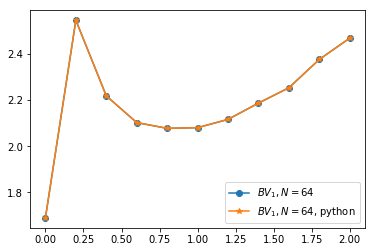

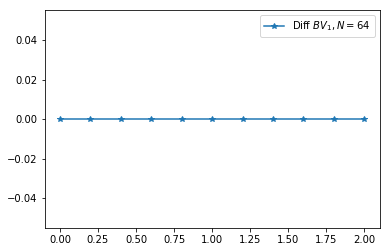

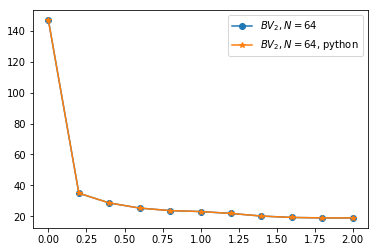

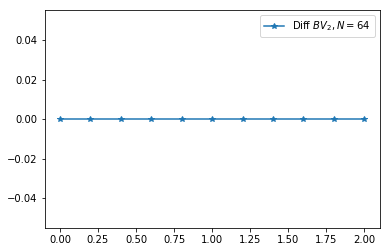

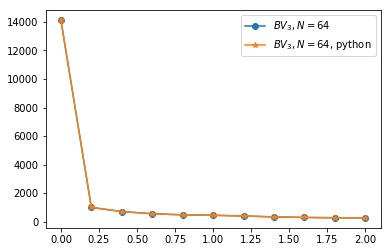

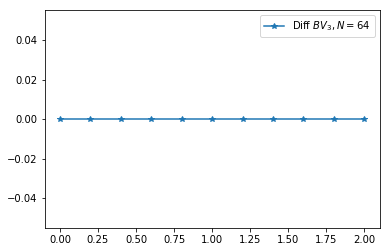

omp max threads= 8
[[  2.57910072e+00   3.86865107e+00   0.00000000e+00   3.22387590e-01]
 [  2.81250000e+00   6.32812500e+00   0.00000000e+00   4.39453125e-02]
 [  3.14257643e+00   1.06061955e+01   0.00000000e+00   6.13784459e-03]]


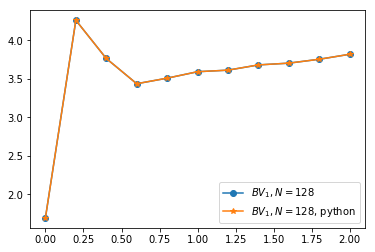

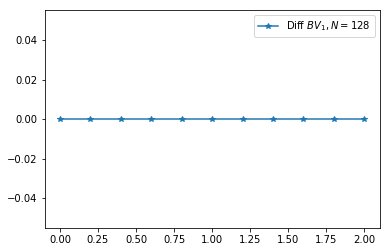

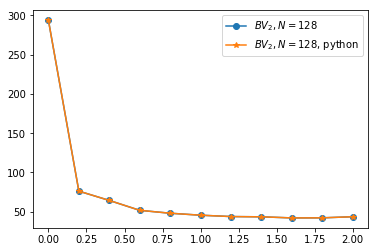

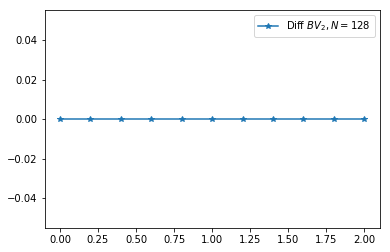

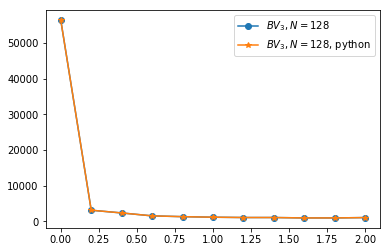

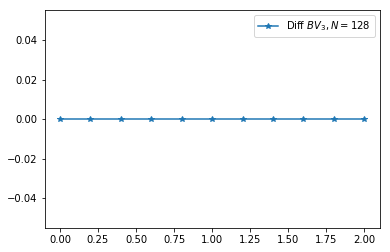

omp max threads= 8
[[  2.59634374e+00   3.89451561e+00   0.00000000e+00   3.24542967e-01]
 [  2.83203125e+00   6.37207031e+00   0.00000000e+00   4.42504883e-02]
 [  3.16534373e+00   1.06830351e+01   0.00000000e+00   6.18231196e-03]]


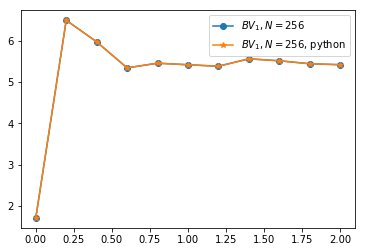

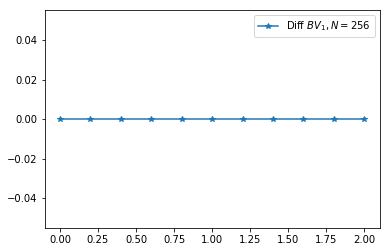

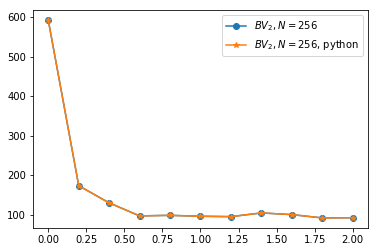

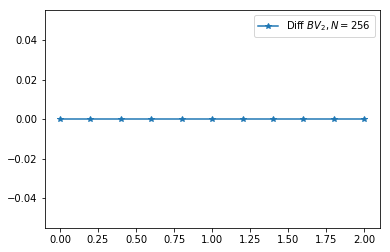

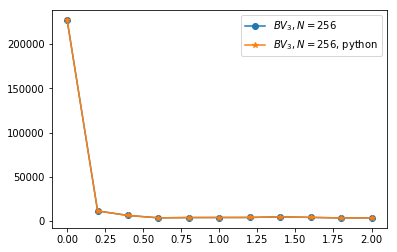

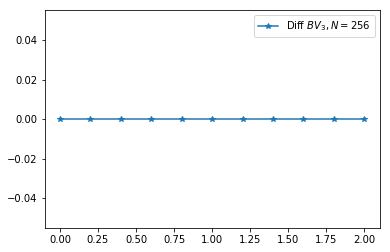

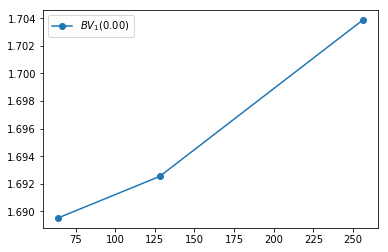

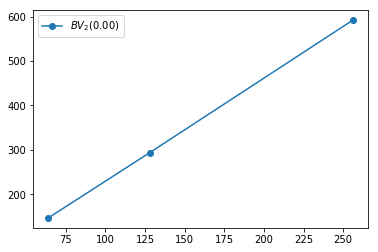

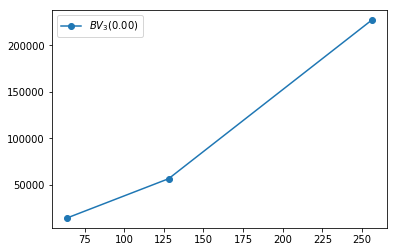

In [14]:
NT = 10
P=[1,2,3]
R = [64, 128, 256]#,512,1024]
BV = zeros((len(R), NT+1,len(P)))
BV_py = zeros_like(BV)

for (nr,r) in enumerate(R):
    bv,bv_py = run(r, 'hll3', 'weno2',numberOfSaves=NT)
    print bv[0]/r
    for t in range(NT+1):
        for p in P:
            BV[nr, t,p-1]=sum(bv[t,p-1,:])/(4.*float(r)**(2-p))
            BV_py[nr, t, p-1]=sum(bv_py[t,p-1,:])/(4.*float(r)**(2-p))
    for p in P:
        T = linspace(0,2,NT+1)
        plt.plot(T,BV[nr, :,p-1],'-o',label='$BV_{%d}, N=%d$' % (p,r))
        plt.plot(T,BV_py[nr, :,p-1],'-*',label='$BV_{%d}, N=%d$, python' % (p,r))
        plt.legend()
        plt.show()
        
        plt.plot(T,BV_py[nr, :,p-1]-BV[nr, :,p-1],'-*',label='Diff $BV_{%d}, N=%d$' % (p,r))
        plt.legend()
        plt.show()
    
for p in P:
    for t in range(0,1):#NT+1,4):

        plt.plot(R,BV[:,t,p-1],'-o',label='$BV_{%d}(%.2f)$' % (p,t/(float(NT)*2.0)))
        #plt.plot(R,BV_py[:,t,p-1],'-o',label='$BV_{%d}(%.2f) python$' % (p,t/(float(NT)*2.0)))
    plt.legend()        
    plt.show()

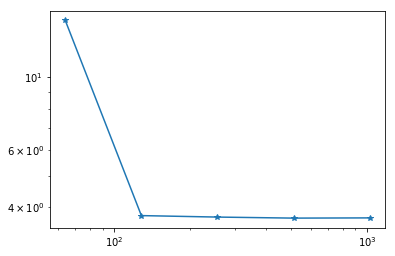

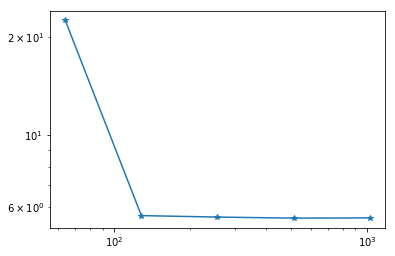

In [40]:
plt.loglog([64, 128, 256, 512, 1024], bvs0, '*-')
plt.show()
plt.loglog([64, 128, 256, 512, 1024], bvs1, '*-')
plt.show()

In [42]:
print bvs0
print bvs1

print bv

[14.9375, 3.7734375, 3.734375, 3.70703125, 3.712890625]
[22.40625, 5.66015625, 5.6015625, 5.560546875, 5.5693359375]
[ 3802.    5703.       0.     475.25]


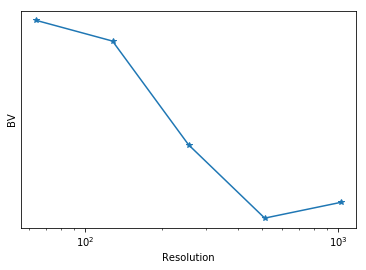

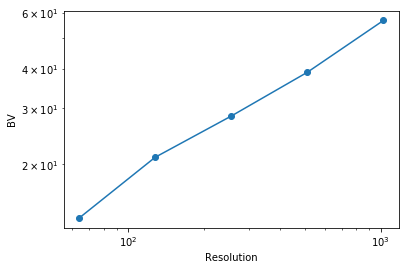

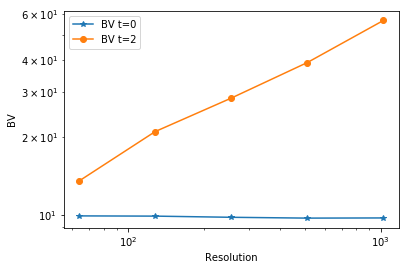

In [47]:
plt.loglog([64, 128, 256, 512, 1024], bvs0, "-*",label='BV t=0')
plt.xlabel('Resolution')
plt.ylabel('BV')
plt.show()
plt.loglog([64, 128, 256, 512, 1024], bvs1, "-o",label='BV t=2')
plt.xlabel('Resolution')
plt.ylabel('BV')
plt.show()
plt.loglog([64, 128, 256, 512, 1024], bvs0, "-*", label='BV t=0')
plt.loglog([64, 128, 256, 512, 1024], bvs1, "-o", label='BV t=2')

plt.xlabel('Resolution')
plt.ylabel('BV')
plt.legend()
plt.show()

In [26]:
basename='kh_bv/kelvinhelmholtz_{perturbation}_{resolution}/kh_bv_{time}.nc'
#perturbations=[0.06, 0.025, 0.01, 0.0075, 0.005]
#basename='richtmeyer_mc/richtmeyermeshkov_{perturbation}_{resolution}/rm_bv_{time}.nc'

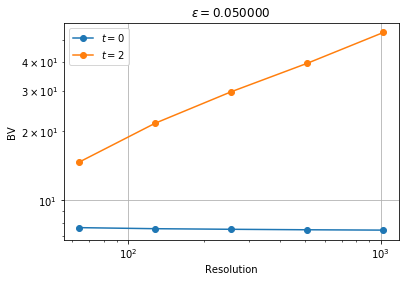

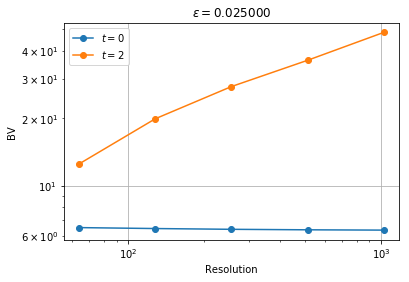

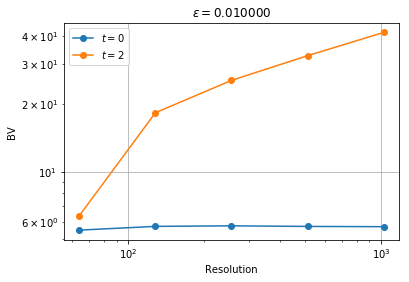

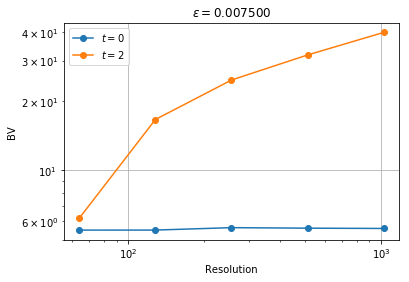

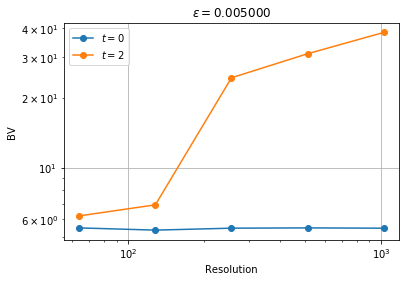

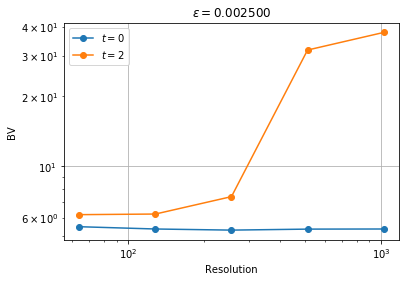

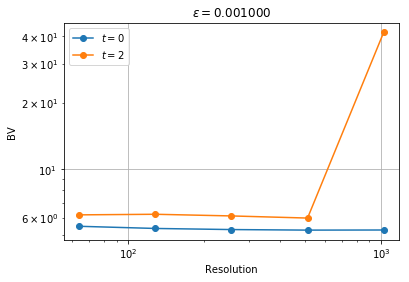

In [27]:
perturbations = [0.05, 0.025, 0.01,0.0075, 0.005,0.0025,0.001]
resolutions=[64,128,256,512,1024]
times=[0,1]
variables=['rho','mx','my','E']
for perturbation in perturbations:
    for time in times:
        bvs = []
        for r in resolutions:
            bv = 0
            with netCDF4.Dataset(basename.format(perturbation=perturbation,resolution=r,time=time)) as f:
                for v in variables:
                    bv +=f.variables[v][0,0,0]/(r)
            bvs.append(bv)
        plt.loglog(resolutions,bvs,'-o',label='$t=%d$'%(2*time))
    plt.grid('on')
    plt.title('$\\epsilon=%f$' % perturbation)
    plt.xlabel('Resolution')
    plt.ylabel('BV')
    plt.legend()
    plt.show()

In [18]:
x,y = mgrid[0:1:128j,0:1:128j]

d = sin(2*pi*x+2*pi*y)

def bv(d):
    return sqrt(abs(diff(d,axis=0))[:,:-1]**2 + abs(diff(d,axis=1))[:-1,:]**2)
bvs = []
r = []
for k in range(5,15):
    N = 2**k
    x,y = mgrid[0:1:N*1j,0:1:N*1j]
    d = sin(2*pi*x+2*pi*y)
    bvs.append(sum(bv(d))/N)
    
    r.append(N)
    
plt.loglog(r,bvs,'-o')
print bvs

MemoryError: 

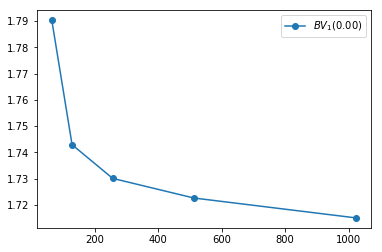

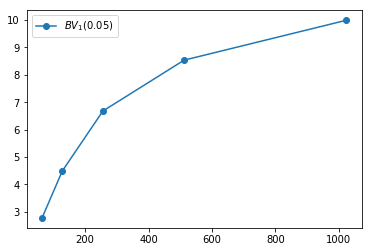

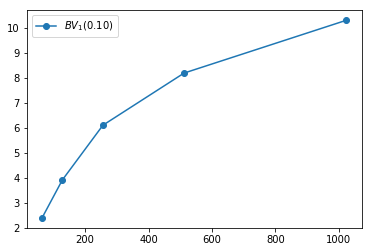

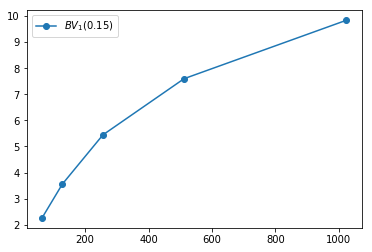

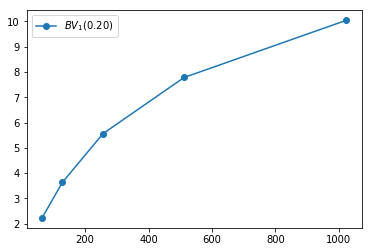

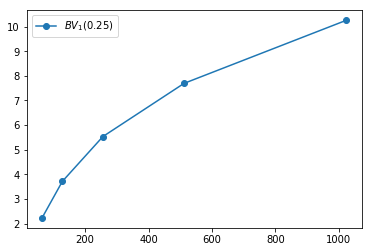

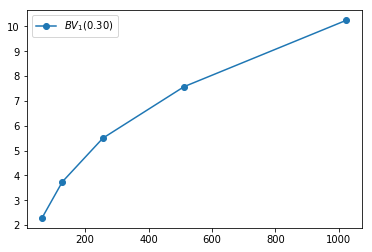

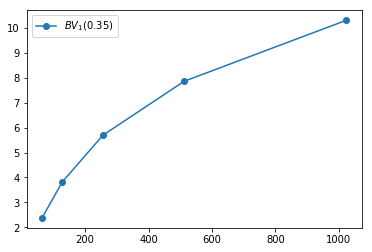

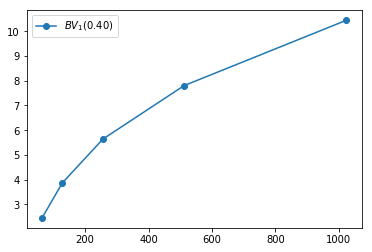

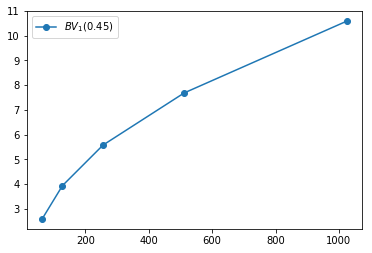

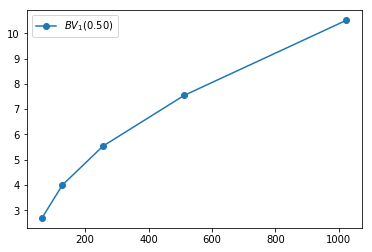

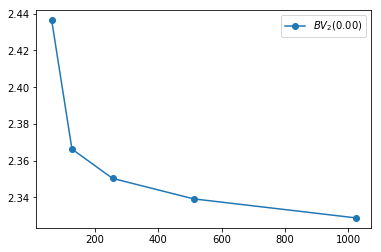

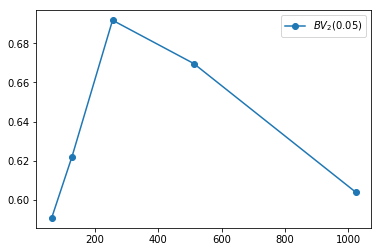

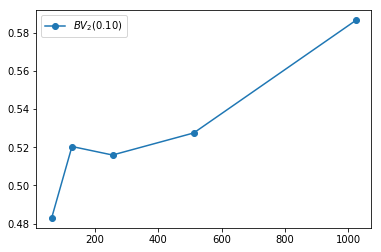

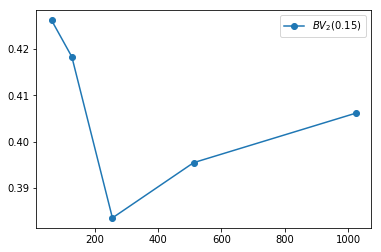

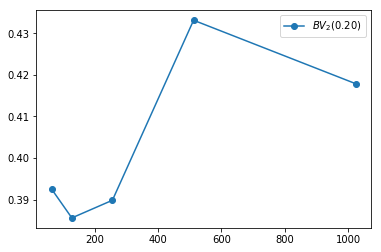

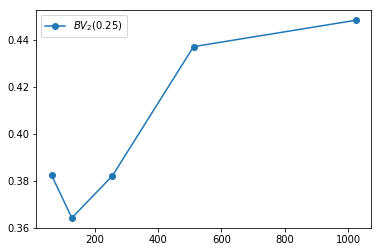

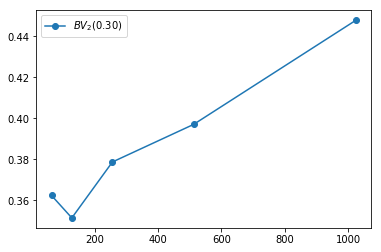

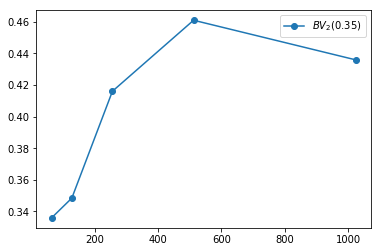

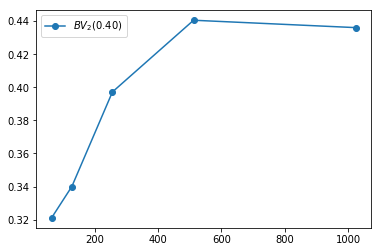

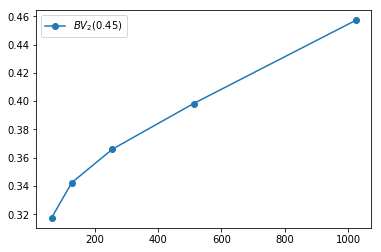

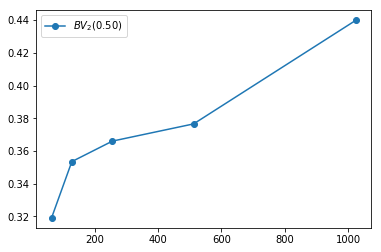

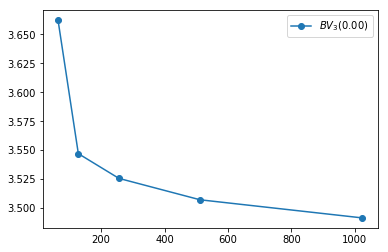

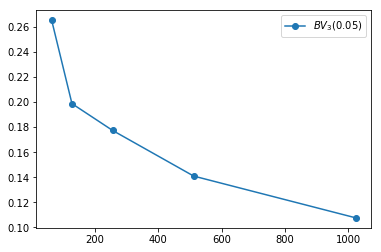

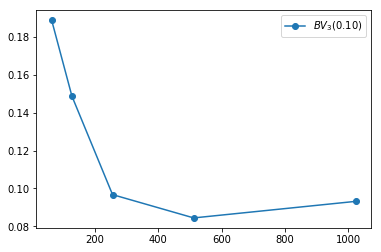

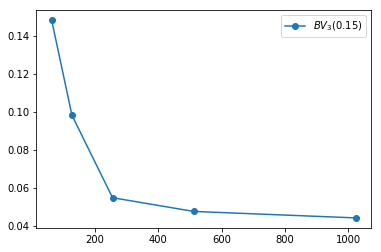

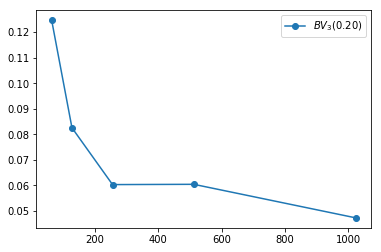

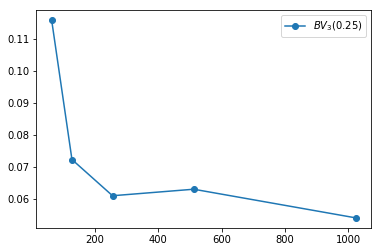

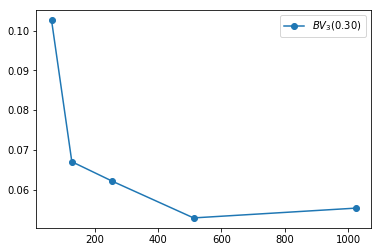

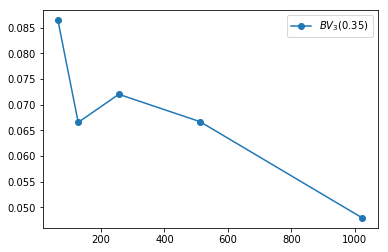

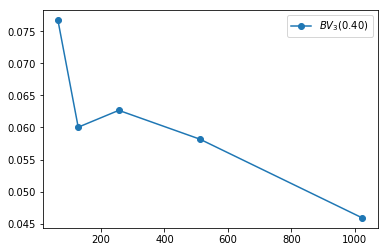

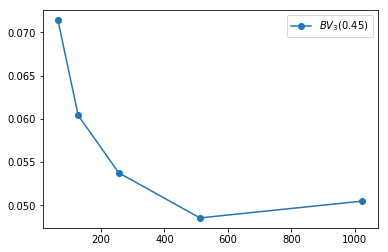

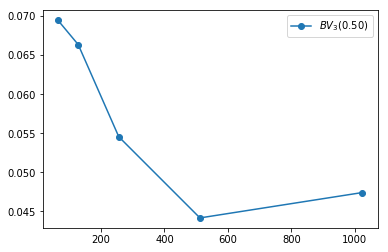

In [17]:
for p in P:
    for t in range(NT+1):

        plt.plot(R,BV[:,t,p-1],'-o',label='$BV_{%d}(%.2f)$' % (p,t/(float(NT)*2.0)))
        plt.legend()        
        plt.show()

Saving new_bv_res_1_0
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


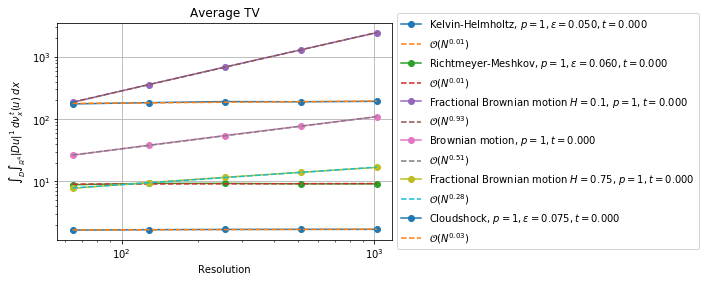

Saving new_bv_res_2_0
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


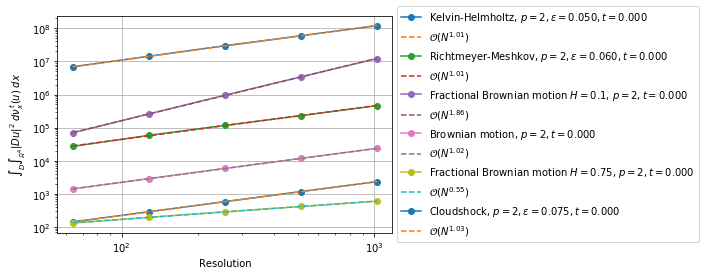

Saving new_bv_res_3_0
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


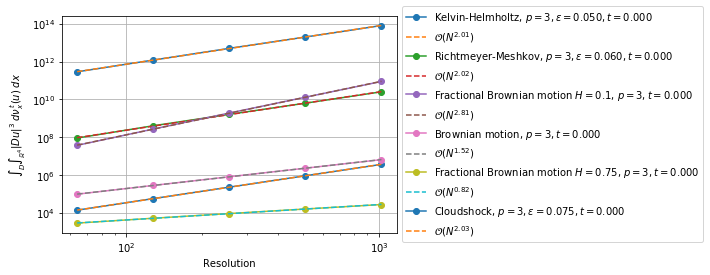

Saving new_bv_res_1_10
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


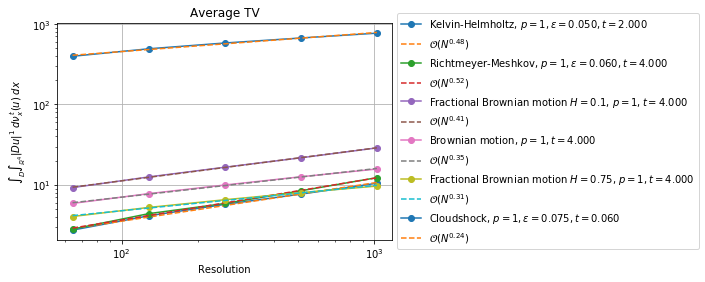

Saving new_bv_res_2_10
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


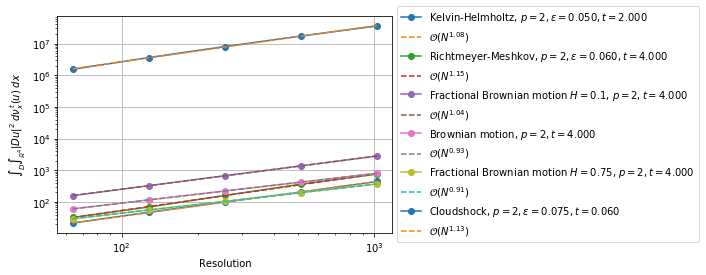

Saving new_bv_res_3_10
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


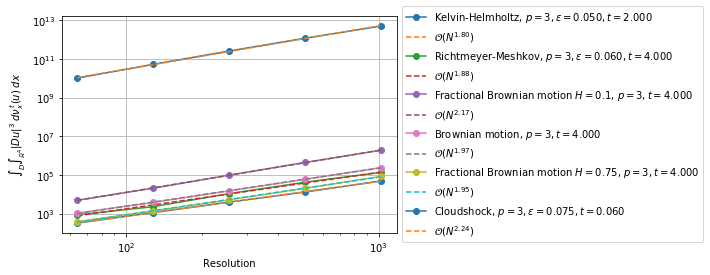

Saving new_bv_res_1_0_dir
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


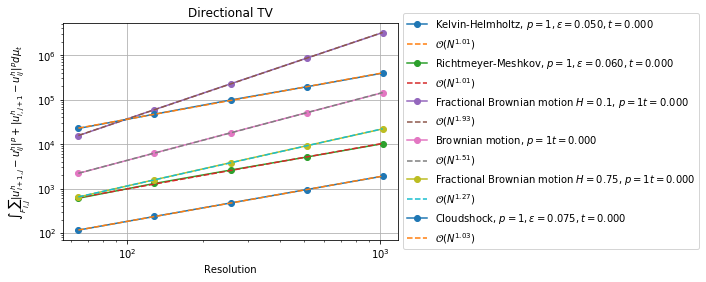

Saving new_bv_res_2_0_dir
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


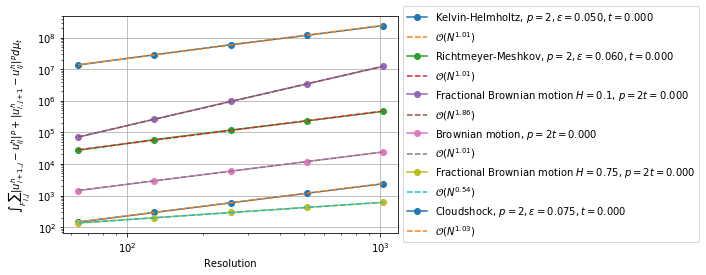

Saving new_bv_res_3_0_dir
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


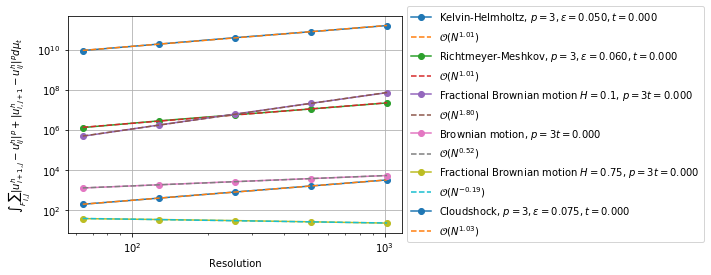

Saving new_bv_res_1_10_dir
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


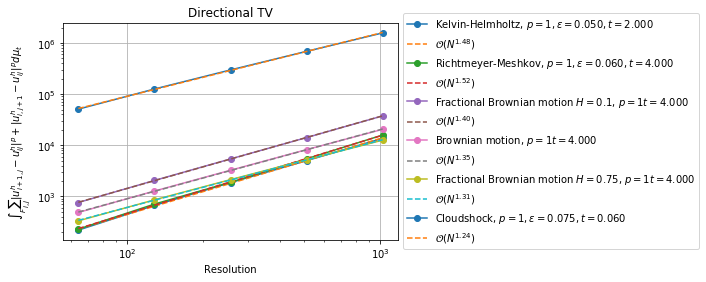

Saving new_bv_res_2_10_dir
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


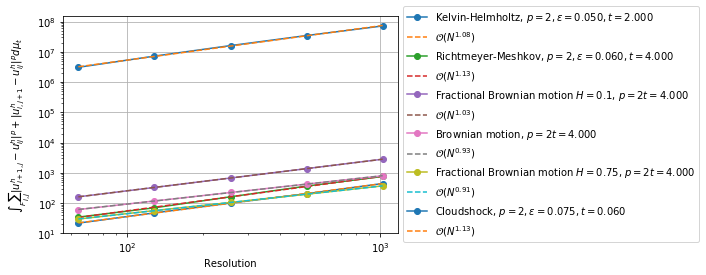

Saving new_bv_res_3_10_dir
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
\usepgfplotslibrary{plotmarks}


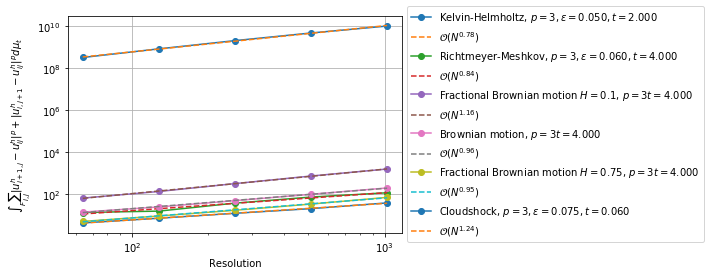

In [5]:
class BV(object):
    def __init__(self):
        self.basenames = {'kh' : 'bv/kh/kelvinhelmholtz_{perturbation}_{resolution}/kh_bv_{p}_{time}.nc',
                         'rm' : 'bv/rm/richtmeyermeshkov_{perturbation}_{resolution}/rm_bv_{p}_{time}.nc',
                          'cloudshock': 'bv/cloudshock/cloudshock_{perturbation}_{resolution}/cloudshock_bv_{p}_{time}.nc',
                          'fbm05': 'bv/fbm/euler_brownian_0.5_{resolution}/eulerbrownian_bv_{p}_{time}.nc',
                          'fbm01': 'bv/fbm/euler_brownian_0.1_{resolution}/eulerbrownian_bv_{p}_{time}.nc',
                          'fbm075': 'bv/fbm/euler_brownian_0.75_{resolution}/eulerbrownian_bv_{p}_{time}.nc',
                          
                         }
        
        
        self.basenames_direction = {'kh' : 'bv/kh/kelvinhelmholtz_{perturbation}_{resolution}/kh_bv_{d}_{p}_{time}.nc',
                         'rm' : 'bv/rm/richtmeyermeshkov_{perturbation}_{resolution}/rm_bv_{d}_{p}_{time}.nc',
                                    'cloudshock': 'bv/cloudshock/cloudshock_{perturbation}_{resolution}/cloudshock_bv_{p}_{time}.nc',
                          'fbm05': 'bv/fbm/euler_brownian_0.5_{resolution}/eulerbrownian_bv_{d}_{p}_{time}.nc',
                          'fbm01': 'bv/fbm/euler_brownian_0.1_{resolution}/eulerbrownian_bv_{d}_{p}_{time}.nc',
                          'fbm075': 'bv/fbm/euler_brownian_0.75_{resolution}/eulerbrownian_bv_{d}_{p}_{time}.nc',
                          }
        self.variables = ['rho', 'mx', 'my', 'E']
    def getBV(self, name, perturbation=0.1, resolution=128, time=0, p=1):
        with netCDF4.Dataset(self.basenames[name].format(perturbation=perturbation, resolution=resolution, time=time, p=p)) as f:
            bv = 0
            for v in self.variables:
                d = f.variables[v][0,0,0]
                bv += d/(len(self.variables)*float(resolution)**(2-p))
            return bv
        
    def getBV_direction(self, name, perturbation=0.1, resolution=128, time=0, p=1):
        bv = 0
        for d in ['x','y']:
            with netCDF4.Dataset(self.basenames_direction[name].format(perturbation=perturbation, resolution=resolution, time=time, p=p,d=d)) as f:
                
                for v in self.variables:
                    d = f.variables[v][0,0,0]
                    bv += d/(len(self.variables))
        return bv
    
    
    def getPerturbations(self, name):
        if name == 'kh':
            return [0.05]
        elif name == 'rm':
            return [ 0.06]
        elif name == 'cloudshock':
            return [0.075]
        elif name == 'fbm01':
            return [0.1]
        elif name == 'fbm05':
            return [0.5]
        elif name == 'fbm075':
            return [0.75]
            #return [0.05,0.01]
        
    def getTimes(self, name):
        if name == 'kh':
            times = {0:0,10:2}
            #for t in range(0,11):
            #    times[t] = 2.0/10.*t
            return times
        elif name == 'rm':
            times = {0:0,10:4}
            #for t in range(0,11):
            #    times[t] = 4.0/10.*t
            return times
        elif name == 'cloudshock':
            return {0:0,10:0.06}
        elif name == 'fbm01':
            return {0:0,10:4}
        elif name == 'fbm05':
            return {0:0,10:4}
        elif name == 'fbm075':
            return {0:0,10:4}
        
        
        
    def getResolutions(self, name):
        return [64,128,256,512,1024]
    
    def getName(self, name):
        if name =='kh':
            return 'Kelvin-Helmholtz'
        elif name == 'rm':
            return 'Richtmeyer-Meshkov'
        elif name == 'cloudshock':
            return 'Cloudshock'
        elif name == 'fbm01':
            return 'Fractional Brownian motion $H=0.1$'
        elif name == 'fbm05':
            return 'Brownian motion'
        elif name == 'fbm075':
            return 'Fractional Brownian motion $H=0.75$'
        

bv = BV()


def plotTime(name):
    bv = BV()
    for r in bv.getResolutions(name):
        for p in [1,2,3]:
            for pert in bv.getPerturbations(name):
                times = bv.getTimes(name)
                bvs = []
                T = []
                for t in times.keys():
                    bvs.append(bv.getBV(name, perturbation=pert, p=p,time=t, resolution=r))
                    T.append(times[t])
                plt.plot(T, bvs, '-o',label='$p=%d, \epsilon=%.3f$' % (p,pert))
            plt.xlabel('$t$')
            plt.ylabel('$\\int_{D}\\int_{\\mathbb{R}^4}|Du|^{%d}\;d\\nu^{t}_x(u)\;dx$' % p)
            if p == 1:
                plt.title('Average TV for %s with $N_x=M=%d$' % (bv.getName(name), r))
            else:
                plt.title('%s $N_x=M=%d$' % (bv.getName(name), r))
            plt.legend()
            plt.grid('on')
            showAndSave('bv_time_{p}_{r}_{name}'.format(p=p,r=r,name=name))
            
def plotScaling(resolution, bv):
    poly = polyfit(log(resolution), log(bv),1)
    plt.loglog(resolution, exp(poly[1])*resolution**poly[0], '--',label='$\\mathcal{O}(N^{%.2f})$' % poly[0])
def plotResolution(names):
    if type(names) == str:
        names = [names]
    
    bv = BV()
    
    for t in [0,10]:
        for p in [1,2,3]:
       
            for name in names:
                times = bv.getTimes(name)
                pert = bv.getPerturbations(name)[0]
        
            
                plt.figure(t*3+p-1)
                
                bvs = []
                R = []
                for r in bv.getResolutions(name):            
                    bvs.append(bv.getBV(name, perturbation=pert, p=p,time=t, resolution=r))
                    R.append(r)
                if 'fbm' not in name:
                    label = '%s, $p=%d, \epsilon=%.3f, t=%.3f$' % (bv.getName(name), p,pert,times[t])
                else:
                    label = '%s, $p=%d, t=%.3f$' % (bv.getName(name), p,times[t])
                    
                
                plt.loglog(R, bvs, '-o',label=label)
                plotScaling(R, bvs)
                
                plt.xlabel('Resolution')
                plt.ylabel('$\\int_{D}\\int_{\\mathbb{R}^4}|Du|^{%d}\;d\\nu^{t}_x(u)\;dx$' % p)
                if p == 1:
                    plt.title('Average TV')
                
                #plt.legend()
            plt.grid('on')
    
            ax = plt.gca()
            lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
            showAndSave('new_bv_res_{p}_{t}'.format(pert=pert,t=t,p=p,r=r,name=name),legend=lgd)
                    
                
def plotTimeDirection(name):
    bv = BV()
    for r in bv.getResolutions(name):
        for p in [1,2,3]:
            for pert in bv.getPerturbations(name):
                times = bv.getTimes(name)
                bvs = []
                T = []
                for t in times.keys():
                    bvs.append(bv.getBV_direction(name, perturbation=pert, p=p,time=t, resolution=r))
                    T.append(times[t])
                plt.plot(T, bvs, '-o',label='$p=%d, \epsilon=%.3f$' % (p,pert))
            plt.xlabel('$t$')
            plt.ylabel('$\\int_{F} \\sum_{i,j} |u^h_{i+1,j}-u^h_{ij}|^p + |u^h_{i,j+1} - u^h_{ij}|^p d\\mu_t $')
            if p == 1:
                plt.title('Average TV for %s with $N_x=M=%d$' % (bv.getName(name), r))
            else:
                plt.title('%s $N_x=M=%d$' % (bv.getName(name), r))
            plt.legend()
            plt.grid('on')
            showAndSave('new_bv_time_dir_{p}_{r}_{name}'.format(p=p,r=r,name=name))
            
def plotResolutionDirection(names):
    if type(names) == str:
        names = [names]
    
    bv = BV()
    
    
        
    
    for t in [0,10]:
           
       
        for p in [1,2,3]:
            for name in names:
                pert = bv.getPerturbations(name)[0]
                times = bv.getTimes(name)
                plt.figure(t*3+p-1)
                
                bvs = []
                R = []
                for r in bv.getResolutions(name):            
                    bvs.append(bv.getBV_direction(name, perturbation=pert, p=p,time=t, resolution=r))
                    R.append(r)
                if 'fbm' not in name:
                    label = '%s, $p=%d, \epsilon=%.3f, t=%.3f$' % (bv.getName(name), p,pert,times[t])
                else:
                    label = '%s, $p=%d t=%.3f$' % (bv.getName(name), p,times[t])
                    
                
                plt.loglog(R, bvs, '-o',label=label)
                plotScaling(R, bvs)
                
                plt.xlabel('Resolution')
                plt.ylabel('$\\int_{F} \\sum_{i,j} |u^h_{i+1,j}-u^h_{ij}|^p + |u^h_{i,j+1} - u^h_{ij}|^p d\\mu_t $')
                if p == 1:
                    plt.title('Directional TV')
                
               
            plt.grid('on')

            
        
            ax = plt.gca()
            lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            showAndSave('new_bv_res_{p}_{t}_dir'.format(pert=pert,t=t,p=p,r=r,name=name),legend=lgd)
                        
plotResolution(['kh','rm','fbm01','fbm05','fbm075','cloudshock'])
plotResolutionDirection(['kh','rm','fbm01','fbm05','fbm075','cloudshock'])
#plotResolution('kh')
##plotTime('kh')
#plotResolution('cloudshock')
##plotTime('cloudshock')
#plotResolution('fbm01')
##plotTime('fbm01')
#plotResolution('fbm05')
##plotTime('fbm05')
#plotResolution('fbm075')
##plotTime('fbm075')
#plotResolution('rm')
##plotTime('rm')
#
#
#plotResolutionDirection('kh')
##plotTimeDirection('kh')
#plotResolutionDirection('cloudshock')
##plotTimeDirection('cloudshock')
#plotResolutionDirection('fbm01')
##plotTimeDirection('fbm01')
#plotResolutionDirection('fbm05')
##plotTimeDirection('fbm05')
#plotResolutionDirection('fbm075')
##plotTimeDirection('fbm075')
#plotResolutionDirection('rm')
##plotTimeDirection('rm')